In [1]:
pip install adversarial-robustness-toolbox

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/nottombrown/imagenet_stubs

  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs 'C:\Users\User\AppData\Local\Temp\pip-req-build-5xilet40'



  Cloning https://github.com/nottombrown/imagenet_stubs to c:\users\user\appdata\local\temp\pip-req-build-5xilet40
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [4]:
# Pretrained Models 
from keras.applications.densenet import DenseNet169, preprocess_input as densenet_preprocess_input 

from keras.preprocessing import image

# Load ART dependencies:
from art.estimators.classification import KerasClassifier

# Attacks 
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod 
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import DeepFool
from art.attacks.evasion import FrameSaliencyAttack
from art.attacks.evasion import HopSkipJump
# Defenses 
from art.defences.preprocessor import SpatialSmoothing
from art.defences.preprocessor import FeatureSqueezing
from art.defences.preprocessor import GaussianAugmentation
from art.defences.preprocessor import LabelSmoothing

# Install ImageNet:
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

E:\Anaconda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E:\Anaconda\envs\tf\lib\site-packages\art\estimators\certification\__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [8]:
import numpy as np
from datetime import datetime 
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# Install ImageNet stubs:
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [9]:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

tf.compat.v1.experimental.output_all_intermediates(True) 

import warnings
warnings.filterwarnings('ignore')

In [10]:
#LOADING IMAGES

import tensorflow.keras.preprocessing.image as image
images_list = list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)
    print (image_path)
    if 'koala.jpg' in image_path:
        # get unicycle index
        koala_idx = i
images = np.array(images_list)

E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\bagel.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\beagle.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\centipede.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\flagpole.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\gazelle.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\koala.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\malamute.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\manhole_cover.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\marmoset.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\mitten.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\notebook_computer.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\rock_crab.jpg
E:\Anaconda\envs\tf\lib\site-packages\imagenet_stubs\images\sleeping_bag.jpg
E:\Anaconda\envs\tf\lib\site-packages\imag

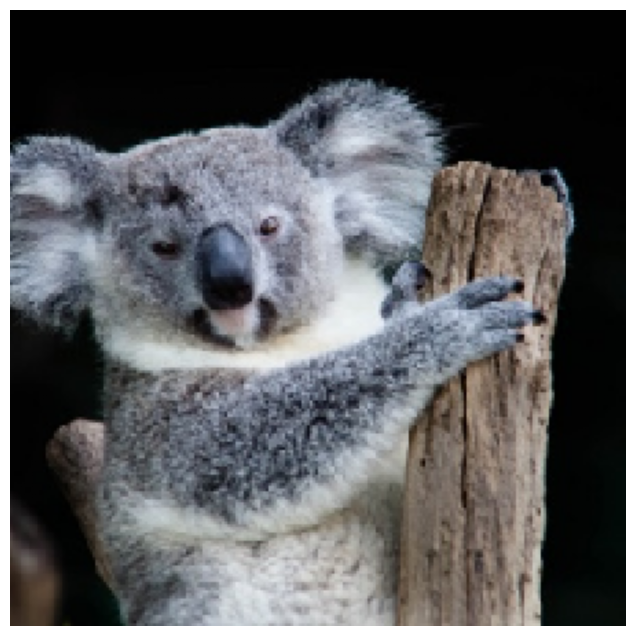

In [11]:
idx = koala_idx

plt.figure(figsize=(8,8)); plt.imshow(images[idx] / 255); plt.axis('off'); plt.show()

In [12]:
#Loading DenseNet169
# This loads the pretrained DenseNet169 model(DenseNet169 is a deep convolutional neural network (CNN) architecture):
model = DenseNet169(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# We need to expand the input dimension and apply the preprocessing required for DenseNet169:
x = np.expand_dims(images[idx].copy(), axis=0)
x = densenet_preprocess_input(x)

# Then apply the model, determine the predicted label and confidence:
pred = model.predict(x)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00


In [14]:
from art.preprocessing.preprocessing import Preprocessor

class DenseNet169Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return densenet_preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1]

In [15]:
# Create the ART preprocessor and classifier wrapper:
preprocessor = DenseNet169Preprocessor()
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=preprocessor)

In [16]:
# Same as for the original model, we expand the dimension of the inputs.
x_art = np.expand_dims(images[idx], axis=0) 

# Then apply the model through the classifier API, determine the predicted label and confidence:
pred = classifier.predict(x_art)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00


In [14]:
#Apply Attack (PGD - Projected Gradient Descent)

# Create the attacker: 
# targeted=True, eps_step=1, eps=8, max_iter=10 
adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=2, eps_step=1, eps=4)  
# Low max_iter = 2, eps = 4 
# Middle max_iter = 3, eps = 8 
# High max_iter = 10, eps = 8 

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
# plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

PGD - Random Initializations: 100%|██████████████████████████████████████████████████████| 1/1 [01:35<00:00, 95.28s/it]


Prediction: impala, Aepyceros melampus - confidence 0.88


In [17]:
#Apply Attack (FGSM- Fast Gradient Sign Method)

from art.attacks.evasion import FastGradientMethod 

adv = FastGradientMethod(estimator=classifier, eps=5)

x_art_adv = adv.generate(x_art)

pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

Prediction: indri, indris, Indri indri, Indri brevicaudatus - confidence 0.26


In [18]:
#Apply Attack (BIM - Basic Iterative Method)

from art.attacks.evasion import BasicIterativeMethod 

adv = BasicIterativeMethod(estimator=classifier, targeted=False, eps=5, max_iter=50, eps_step=1)

x_art_adv = adv.generate(x_art)

pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

PGD - Random Initializations: 100%|██████████████████████████████████████████████████████| 1/1 [01:34<00:00, 94.16s/it]


Prediction: indri, indris, Indri indri, Indri brevicaudatus - confidence 1.00


In [19]:
#Apply Defense

#Spatial Smoothing is applied

# Initalize the SpatialSmoothing defence. 
ss = SpatialSmoothing(window_size=3) 

# window_size = 3 => wrong predicstion with high accuracy 
# window_size = 5 => result is good correct prediction with 71% confidence 
# window_size = 7 => result is prefect correct prediction with 99% confidence // Middle strength 

In [20]:
x_art_def, _ = ss(x_art)
x_art_adv_def, _ = ss(x_art_adv)

In [21]:
# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

In [22]:
# Print the predictions:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))

Prediction of original sample: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 0.99
Prediction of adversarial sample: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 0.41


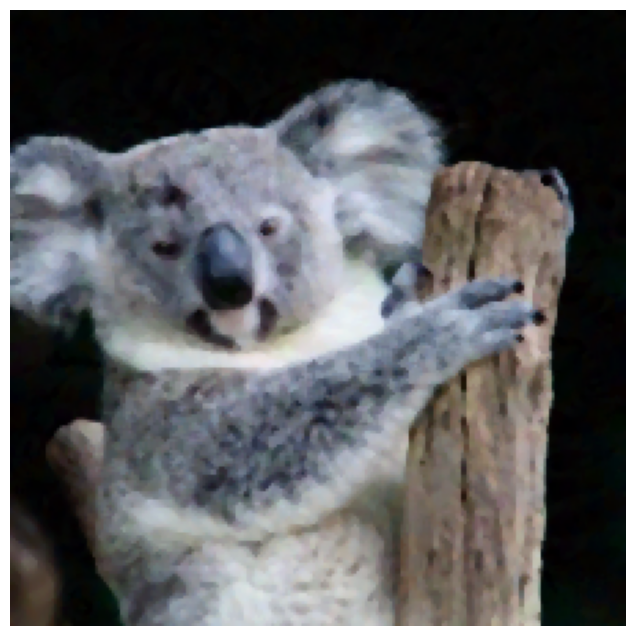

In [23]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

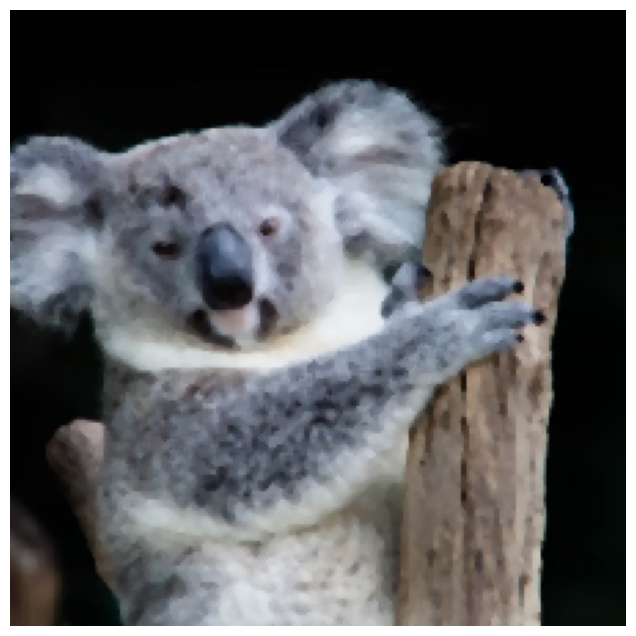

In [24]:
 # Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_def[0] / 255); plt.axis('off'); plt.show()

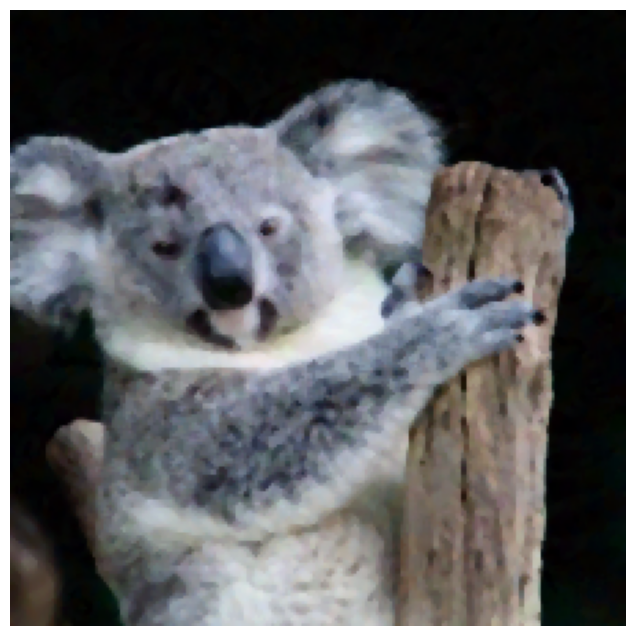

In [25]:
# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

In [26]:
#Gaussian Data Augmentation is applied

# Initalize the Gaussian Augmentation defence.  
gda = GaussianAugmentation(sigma=9, augmentation=False)

# Sigma 9 is High Strength = wrong predicstion with 97% confidence
# Sigma 9 is High Strength = wrong predicstion with 99% confidence // PGD strength is increased 

# Sigma = 9 (High) 
# Sigma = 6 (Middle) 
# Sigma = 3 (Low)

In [27]:
x_art_gda_def, _ = gda(x_art)
x_art_adv_gda_def, _ = gda(x_art_adv)

In [28]:
# Compute the classifier predictions on the preprocessed inputs:
pred_gda_def = classifier.predict(x_art_gda_def)
label_gda_def = np.argmax(pred_gda_def, axis=1)[0]
confidence_gda_def = pred_gda_def[:, label_gda_def][0]

pred_adv_gda_def = classifier.predict(x_art_adv_gda_def)
label_adv_gda_def = np.argmax(pred_adv_gda_def, axis=1)[0]
confidence_adv_gda_def = pred_adv_gda_def[:, label_adv_gda_def][0]

In [29]:
# Print the predictions:
print('Prediction of original sample:', label_to_name(label_gda_def), '- confidence {0:.2f}'.format(confidence_gda_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_gda_def), 
      '- confidence {0:.2f}'.format(confidence_adv_gda_def))

Prediction of original sample: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
Prediction of adversarial sample: indri, indris, Indri indri, Indri brevicaudatus - confidence 0.93


# Feature Squeenzing

In [30]:
fs = FeatureSqueezing(bit_depth=3, clip_values=(0, 255))

# bit = 7 low 
# bit = 5 middle 
# bit = 3 high 

In [31]:
x_art_fs_def, _ = fs(x_art)
x_art_adv_fs_def, _ = fs(x_art_adv)

In [32]:
pred_fs_def = classifier.predict(x_art_fs_def)
label_fs_def = np.argmax(pred_fs_def, axis=1)[0]
confidence_fs_def = pred_fs_def[:, label_fs_def][0]

pred_adv_fs_def = classifier.predict(x_art_adv_fs_def)
label_adv_fs_def = np.argmax(pred_adv_fs_def, axis=1)[0]
confidence_adv_fs_def = pred_adv_fs_def[:, label_adv_fs_def][0]

In [33]:
# Print the predictions:
print('Prediction of original sample:', label_to_name(label_fs_def), '- confidence {0:.2f}'.format(confidence_fs_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_fs_def), 
      '- confidence {0:.2f}'.format(confidence_adv_fs_def))

Prediction of original sample: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
Prediction of adversarial sample: indri, indris, Indri indri, Indri brevicaudatus - confidence 0.97


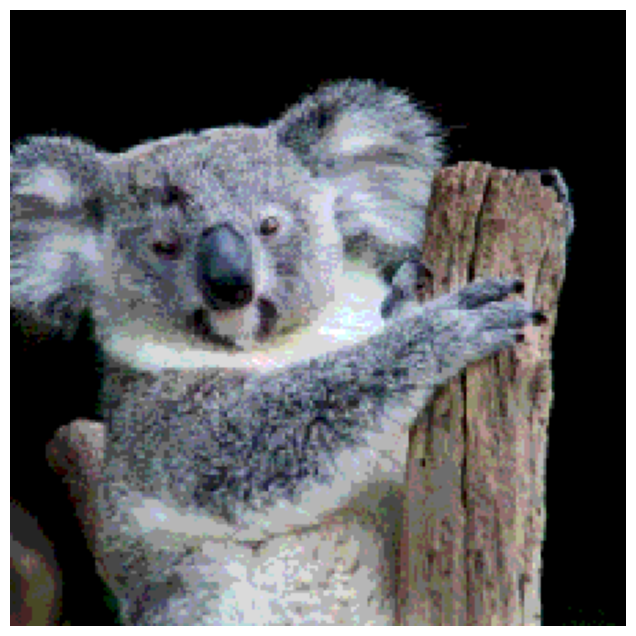

In [34]:
# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_fs_def[0] / 255); plt.axis('off'); plt.show()

In [35]:
#Combine Feature Squeezing and Gaussian Data Augmentation

fs = FeatureSqueezing(bit_depth=3, clip_values=(0, 255)) # Strength = high 
gda = GaussianAugmentation(sigma=9, augmentation=False) # Strength = high

In [36]:
x_art_fs_def, _ = fs(x_art)
x_art_fs_gda_def, _ = gda(x_art_fs_def)

x_art_adv_fs_def, _ = fs(x_art_adv)
x_art_adv_fs_gda_def, _ = gda(x_art_adv_fs_def) 

In [37]:
pred_fs_gda_def = classifier.predict(x_art_fs_gda_def)
label_fs_gda_def = np.argmax(pred_fs_gda_def, axis=1)[0]
confidence_fs_gda_def = pred_fs_gda_def[:, label_fs_gda_def][0]

pred_adv_fs_gda_def = classifier.predict(x_art_adv_fs_gda_def)
label_adv_fs_gda_def = np.argmax(pred_adv_fs_gda_def, axis=1)[0]
confidence_adv_fs_gda_def = pred_adv_fs_gda_def[:, label_adv_fs_gda_def][0]

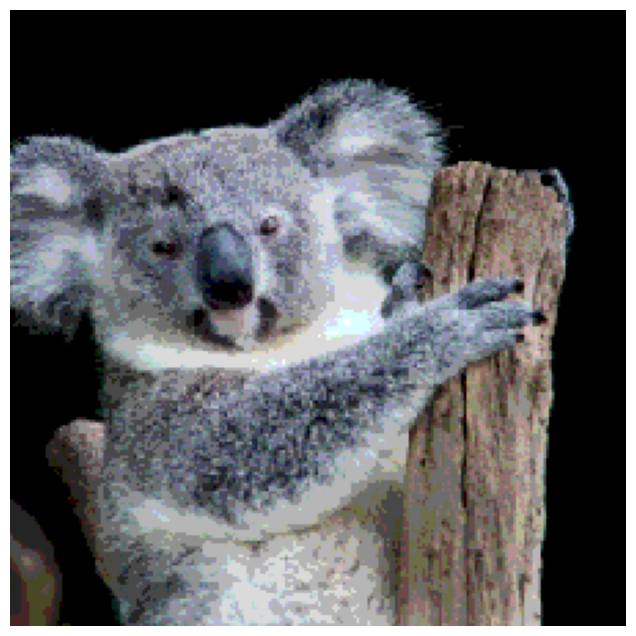

In [38]:
# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_fs_def[0] / 255); plt.axis('off'); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


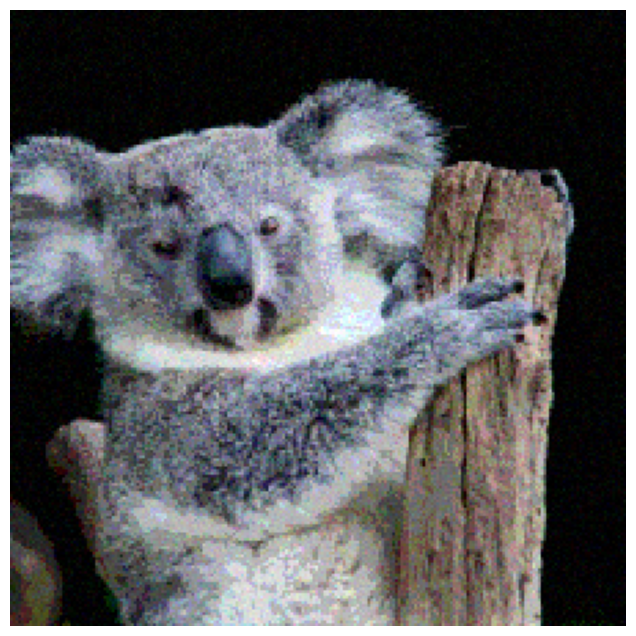

In [39]:
# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_fs_gda_def[0] / 255); plt.axis('off'); plt.show()

In [40]:
# Print the predictions:
print('Prediction of original sample:', label_to_name(label_fs_gda_def), '- confidence {0:.2f}'.format(confidence_fs_gda_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_fs_gda_def), 
      '- confidence {0:.2f}'.format(confidence_adv_fs_gda_def))

Prediction of original sample: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
Prediction of adversarial sample: indri, indris, Indri indri, Indri brevicaudatus - confidence 0.56


In [41]:
#Combine Gaussian Data Augmentation and Spatial Smoothing (weak)

gda = GaussianAugmentation(sigma=3, augmentation=False) # Strength = high (sigma=9), middle (sigma=6), low (sigma=3) 
ss = SpatialSmoothing(window_size=5) # Strength = low (3), middle = 5,

In [42]:
x_art_ss_def, _ = ss(x_art)
x_art_ss_gda_def, _ = gda(x_art_ss_def)

x_art_adv_ss_def, _ = ss(x_art_adv)
x_art_adv_ss_gda_def, _ = gda(x_art_adv_ss_def)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


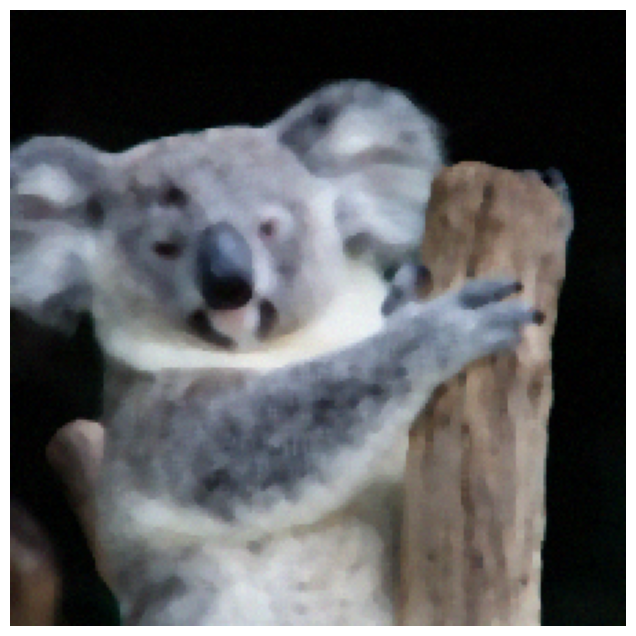

In [43]:
# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_ss_gda_def[0] / 255); plt.axis('off'); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


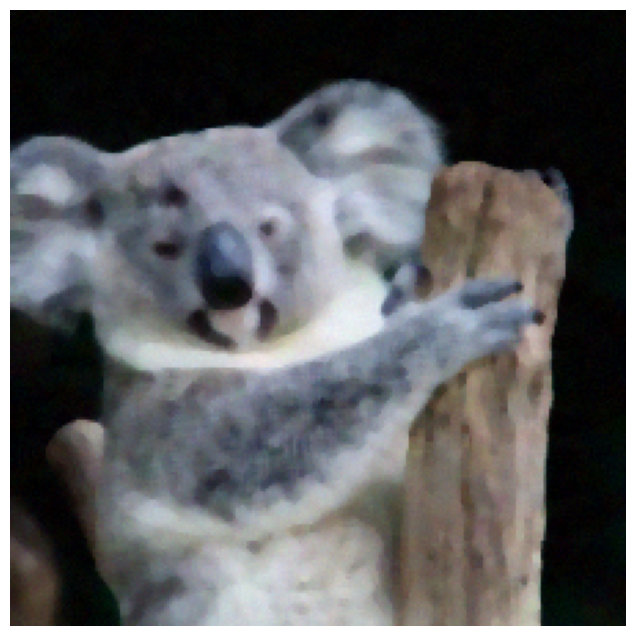

In [44]:
# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_ss_gda_def[0] / 255); plt.axis('off'); plt.show()

In [45]:
pred_ss_gda_def = classifier.predict(x_art_ss_gda_def)
label_ss_gda_def = np.argmax(pred_ss_gda_def, axis=1)[0]
confidence_ss_gda_def = pred_ss_gda_def[:, label_ss_gda_def][0]

pred_adv_ss_gda_def = classifier.predict(x_art_adv_ss_gda_def)
label_adv_ss_gda_def = np.argmax(pred_adv_ss_gda_def, axis=1)[0]
confidence_adv_ss_gda_def = pred_adv_ss_gda_def[:, label_adv_ss_gda_def][0]

In [46]:
# Print the predictions:
print('Prediction of original sample:', label_to_name(label_ss_gda_def), '- confidence {0:.2f}'.format(confidence_ss_gda_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_ss_gda_def), 
      '- confidence {0:.2f}'.format(confidence_adv_ss_gda_def))

Prediction of original sample: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 0.99
Prediction of adversarial sample: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 0.55
